In [1]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

In [2]:
#Read dataset and make ydata-profiling dashboard

#from ydata_profiling import ProfileReport

df = pd.read_csv("./data/datasetData.csv")
#Drop index col
df = df.drop(["Unnamed: 0"], axis=1)
#Remove special symbole
df['AutoML_solution'] = df['AutoML_solution'].str.replace(':', '')
#Apply one hot encoding
df = pd.get_dummies(df, columns=['AutoML_solution'], prefix='', prefix_sep='')

#profile = ProfileReport(df, title="Profiling Report")
#profile.to_notebook_iframe()

In [3]:
#Split data all AutoML together

X = df.drop(["runtime_limit"], axis=1)
y = df["runtime_limit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
#Create prediction plot
def create_prediction_plot(y_test, predictions):
    prediction_results = pd.DataFrame({
        'runtime_limit_is': y_test,
        'runtime_limit_predicted': predictions
    })

    best_case_x = [0, 5, 10, 20, 40, 80, 160, 320, 640]
    best_case_y = [0, 5, 10, 20, 40, 80, 160, 320, 640]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='runtime_limit_predicted', 
        y='runtime_limit_is', 
        data=prediction_results, 
        color='gray', marker='o'  # Using a distinct color palette
    )

    plt.plot(best_case_x, best_case_y)
    plt.xscale('log', base=10)  # Logarithmic scale for x-axis
    plt.yscale('log', base=10)  # Logarithmic scale for y-axis


    # Find the limits in log space
    x_min, x_max = 1, 100
    y_min, y_max = 1, np.exp(6.6)

    # Determine the limits to make them symmetrical in log space
    log_min = min(np.log10(x_min), np.log10(y_min))
    log_max = max(np.log10(x_max), np.log10(y_max))

    # Apply the symmetrical limits
    plt.xlim([10**log_min, 10**log_max])
    plt.ylim([10**log_min, 10**log_max])




    plt.xlabel('Optimal runtime predicted')
    plt.ylabel('Optimal runtime measured')
    #plt.legend(title='AutoML Solution', bbox_to_anchor=(1.05, 0.5), loc='center left')
    #plt.title('Actual vs Predicted Runtime Limits')
    plt.grid(True)
    #plt.legend(title='Series')
    plt.show()
    

In [5]:

selected_feature = ["autogluon", "evalml", "flaml", "gama", "h2o_automl", "lama", "pycaret", "tpot", "dataset_cols"]

In [6]:
def train_model(model,):
    model.fit(X_train[selected_feature], y_train)
    predictions = model.predict(X_test[selected_feature])
    
    # Compute MAE
    mae = MAE(predictions, y_test)

    print(f"{type(model)} Mean Absolute Error (MAE):", round(mae))
    return model

In [7]:

import lightgbm as lgb

def train_lgbm_model(model,):
    train_data = lgb.Dataset(X_train[selected_feature], label=y_train)
    test_data = lgb.Dataset(X_test[selected_feature], label=y_test, reference=train_data)



    # Define parameters for the LightGBM model
    params = {
        'objective': 'regression',  # Set the objective as regression
        'metric': 'mae',            # Use mean absolute error as the evaluation metric
        'verbose': 1                # Disable verbose output
    }

    # Train the LightGBM model
    num_round = 100
    model = lgb.train(params, train_data, num_round)

    # Make predictions on the test set
    predictions = model.predict(X_test[selected_feature], num_iteration=model.best_iteration)
    
    # Compute MAE
    mae = MAE(predictions, y_test)

    print(f"{type(model)} Mean Absolute Error (MAE):", round(mae))
    return model

In [8]:

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

models = { "LightGBM": None, "Baseline": DummyRegressor(strategy="median"), "Linear Regression": LinearRegression(), 
          "Decision Tree": DecisionTreeRegressor(random_state=42), 
          "Sklearn Neural Network": MLPRegressor(random_state=42), "Ridge": Ridge(), 
          "Lasso": Lasso(), "Elastic": ElasticNet(), "Random Forest": RandomForestRegressor(), 
          "Bayesian": BayesianRidge(), "SVM": SVR()}


for model_name, model in models.items():
    if model_name == "LightGBM":
        models[model_name] = train_lgbm_model(model)
    else:
        models[model_name] = train_model(model)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 9
[LightGBM] [Info] Start training from score 105.742188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\alex\Desktop\Meta-Learning\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


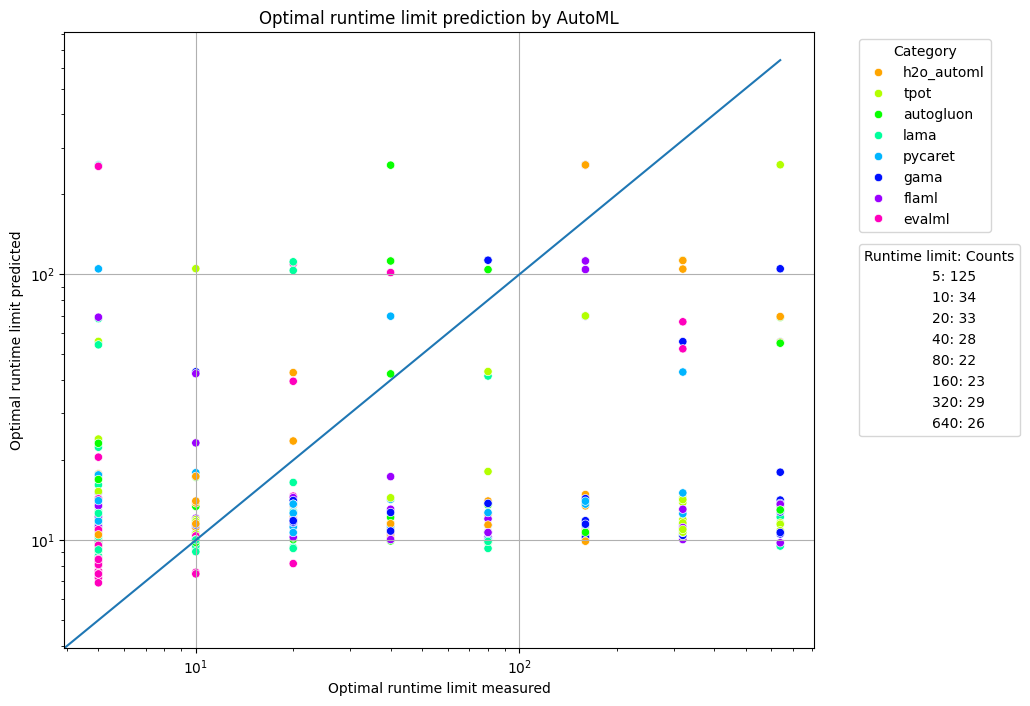

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

# Combine train and test data for predictions
X_all = pd.concat([X_train[selected_feature], X_test[selected_feature]])
y_all = pd.concat([y_train, y_test])

# Make predictions
predictions = models["Sklearn Neural Network"].predict(X_all)

# Create a DataFrame for results
result_df = X_all.copy()
result_df['runtime_limit_is'] = y_all
result_df['runtime_limit_predicted'] = predictions

# Assign categories manually based on the one-hot encoded columns
def get_category(row, category_columns):
    for col in category_columns:
        if row[col] == 1:
            return col.replace('category_', '')
    return None

# Find the one-hot encoded column where it's true for each row
category_columns = ["autogluon", "evalml", "flaml", "gama", "h2o_automl", "lama", "pycaret", "tpot"]
result_df['category'] = result_df.apply(get_category, axis=1, category_columns=category_columns)

# Count the number of dots per x-axis class
dot_counts = result_df['runtime_limit_is'].value_counts().sort_index()

# Plot using Seaborn
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    y='runtime_limit_predicted',
    x='runtime_limit_is',
    hue='category',
    data=result_df,
    palette=sns.color_palette("hsv", len(result_df['category'].unique()))  # Using a distinct color palette
)

# Add a custom legend for the categories
handles, labels = scatter.get_legend_handles_labels()
category_legend = plt.legend(handles, labels, title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(category_legend)

# Create a second legend for the counts with no markers
count_labels = [f'{int(key)}: {value}' for key, value in dot_counts.items()]
count_legend_handles = [Line2D([0], [0], color='white', label=label) for label in count_labels]
count_legend = plt.legend(count_legend_handles, count_labels, title='Runtime limit: Counts', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add the best case line
best_case_x = [0, 5, 10, 20, 40, 80, 160, 320, 640]
best_case_y = [0, 5, 10, 20, 40, 80, 160, 320, 640]
plt.plot(best_case_x, best_case_y)

# Set logarithmic scales
plt.xscale('log', base=10)
plt.yscale('log', base=10)

# Set labels and title
plt.ylabel('Optimal runtime limit predicted')
plt.xlabel('Optimal runtime limit measured')
plt.title('Optimal runtime limit prediction by AutoML')

# Ensure grid is enabled
plt.grid(True)

# Adjust layout to make space for legends
plt.subplots_adjust(right=0.75)

plt.show()
